In [1]:
!pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 29.1 MB/s eta 0:00:00


## **Gold Price Visualization with EMA200**

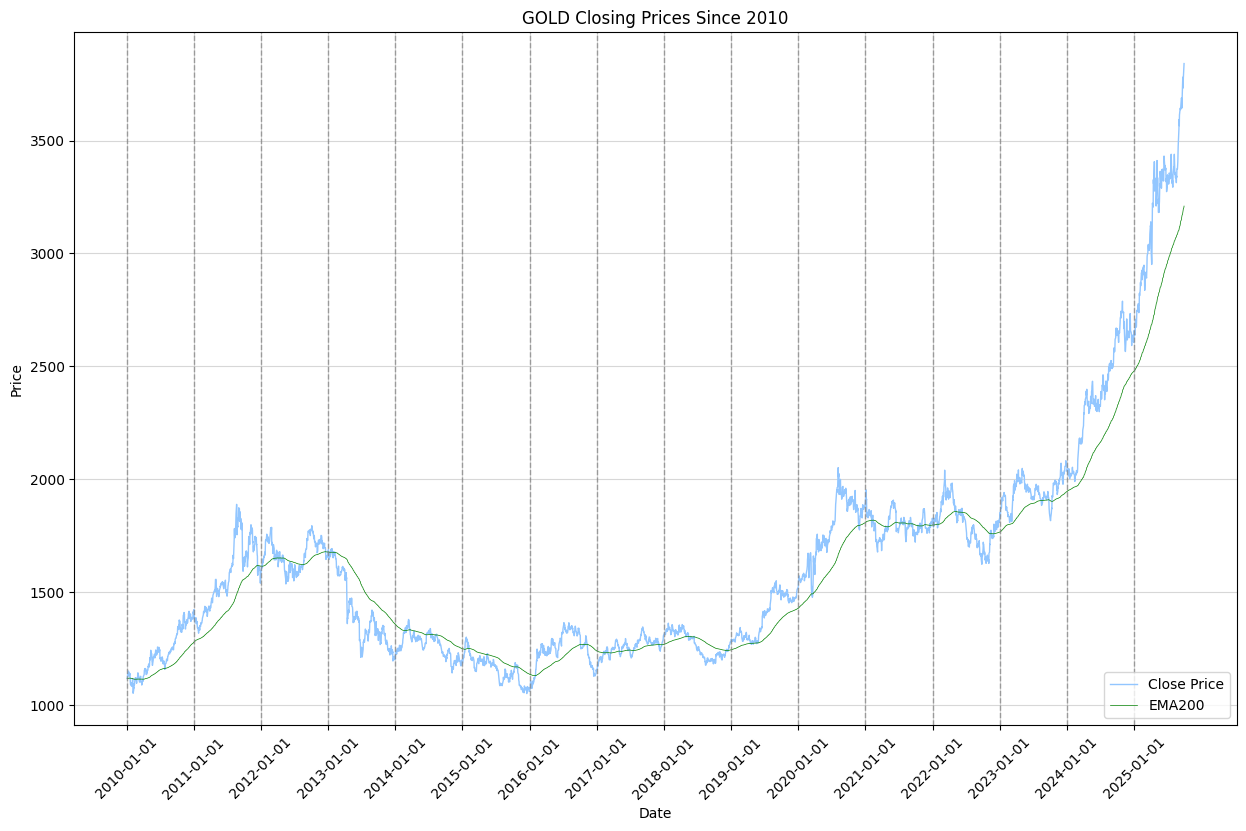


Percentage of Close Price Below EMA200:
+----------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|                | 2010   | 2011   | 2012   | 2013   | 2014   | 2015   | 2016   | 2017   | 2018   | 2019   | 2020   | 2021   | 2022   | 2023   | 2024   | 2025   |
+================+========+========+========+========+========+========+========+========+========+========+========+========+========+========+========+========+
| % Below EMA200 | 14.29% | 4.76%  | 41.20% | 96.03% | 84.92% | 90.48% | 27.60% | 28.69% | 57.20% | 3.17%  | 2.37%  | 57.94% | 56.18% | 7.60%  | 0.00%  | 0.00%  |
+----------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

ticker = "GC=F"
df = yf.Ticker(ticker).history(start="2010-01-01", end="2025-10-01")

df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

plt.figure(figsize=(15, 9))
plt.style.use("seaborn-v0_8-pastel")
plt.title(f"GOLD Closing Prices Since 2010")
plt.grid(True, alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(df["Close"], linewidth=1, label="Close Price")
plt.plot(df["EMA200"], linewidth=0.5, label="EMA200", color='green')
years = pd.date_range(start="2010-01-01", end="2025-10-01", freq="YS", tz=df.index.tz)
plt.xticks(years, rotation=45)
for year in years:
    plt.axvline(x=year, color='grey', alpha = 0.7, linestyle='--', linewidth=1.0)
plt.legend()
plt.show()

yearly_data_list = []
for year in years:
    start_year = year
    end_year = year + pd.DateOffset(years=1) - pd.Timedelta(days=1)
    yearly_df = df[(df.index >= start_year) & (df.index <= end_year)].copy()
    below_count = (yearly_df['Close'] < yearly_df['EMA200']).sum()
    total_days = len(yearly_df)
    percentage = (below_count / total_days) * 100 if total_days > 0 else 0
    yearly_data_list.append({'Year': start_year.year, '% Below EMA200': f"{percentage:.2f}%"})

below_ema_df = pd.DataFrame(yearly_data_list)

transposed_df = below_ema_df.set_index('Year')
transposed_df = transposed_df.T

print("\nPercentage of Close Price Below EMA200:")
print(tabulate(transposed_df, headers='keys', floatfmt=".2f", tablefmt="grid"))


## **XAUUSD LongONLY Strategy Backtest (2010-2023)**

- Excluded 2024 & 2025 here since both years are SUPER BULL year for GOLD, with 100% Close Price > EMA200.

- Doing this could potentially yield a more normalized and reliable result (let's compare at below).

**XAUUSD CFD Trading Specifications:**

- 1 standard lot = 100 ounces of GOLD

- 1 pip = $0.01 movement in GOLD price per ounce

- Pip value = $0.01 * position size in ounce (a stanard lot = 100 oz) = how much per pip

- Margin requirement = Notional Value / Leverage = position size in ounce * GOLD price / 100

- Eg. Margin required = 40 oz (0.4 lot) * 3000 * (1/100) = $1,200 (12% margin usage)

In [3]:
import math
from datetime import datetime
import backtrader as bt
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
from termcolor import colored
import numpy as np

plt.rcParams['figure.figsize'] = [13, 7]
plt.rcParams['figure.dpi'] = 100

INITIAL_CAPITAL = 10000.0
POSITION_SIZE_LOTS = 0.3       # 40 ounces
LEVERAGE = 100
STOP_LOSS_PIPS = 600           # $5.00 per ounce
RISK_PER_TRADE_PCT = 2.0       # Maximum loss 2% of portfolio per trade ($200)

PRINT_DETAILED_TRADE_LOG = False      # print all trades for each year
PRINT_YEARLY_SUMMARY = True           # print summary after each year
PRINT_BACKTEST_SUMMARY = True         # print overall backtest summary table
PLOT_RETURN_DISTRIBUTION = True       # show return distribution plot

FILE_PATH = r"/content/XAUUSD_M15.csv"

def format_profit_loss(value):
    if value < 0:
        return colored(f"${value:.2f}", 'red', attrs=['bold'])
    else:
        return colored(f"${value:.2f}", 'green', attrs=['bold'])

def calculate_returns(profit, initial_capital):
    return (profit / initial_capital) * 100

def calculate_portfolio_drawdown(trade_log, initial_capital):
#    Calculate maximum drawdown from peak portfolio value
#    Also tracks lowest portfolio balance for margin call analysis
    if not trade_log:
        return 0.0, initial_capital, initial_capital, initial_capital

    portfolio_values = [initial_capital]
    for trade in trade_log:
        portfolio_values.append(trade['Portfolio Balance'])

    peak_balance = portfolio_values[0]
    max_drawdown_pct = 0
    peak_at_max_dd = initial_capital
    trough_at_max_dd = initial_capital
    lowest_balance = initial_capital

    for balance in portfolio_values:
        if balance < lowest_balance:
            lowest_balance = balance

        if balance > peak_balance:
            peak_balance = balance

        drawdown_pct = ((peak_balance - balance) / peak_balance * 100) if peak_balance > 0 else 0

        if drawdown_pct > max_drawdown_pct:
            max_drawdown_pct = drawdown_pct
            peak_at_max_dd = peak_balance
            trough_at_max_dd = balance

    return max_drawdown_pct, peak_at_max_dd, trough_at_max_dd, lowest_balance

def calculate_margin_required(price, position_size_lots, leverage):
    ounces = position_size_lots * 100
    notional_value = ounces * price
    margin_required = notional_value / leverage
    return margin_required

def load_data(file_path):
    try:
        raw_data = pd.read_csv(file_path)
        raw_data['datetime'] = pd.to_datetime(raw_data['Date'], format='%Y.%m.%d %H:%M')
        raw_data.set_index('datetime', inplace=True)
        raw_data = raw_data[['Open', 'High', 'Low', 'Close', 'Volume']]
        raw_data.columns = ['open', 'high', 'low', 'close', 'volume']
        print(f"✓ Data loaded successfully. Shape: {raw_data.shape}")
        print(f"✓ Date range: {raw_data.index[0]} to {raw_data.index[-1]}")
        return raw_data
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        return None

class XAUUSDStrategy(bt.Strategy):
    params = (
        ('ema_fast', 20),
        ('ema_mid', 45),
        ('ema_slow', 60),
        ('rsi_period', 14),
        ('rsi_weak', 40),
        ('rsi_mid', 50),
        ('rsi_strong', 60),
        ('rsi_entry_lower', 35),
        ('rsi_entry_upper', 60),
        ('rsi_oversold', 30),
        ('rsi_overbought', 70),
        ('rsi_extreme_oversold', 21),
        ('rsi_extreme_overbought', 84),
        ('bb_period', 20),
        ('position_size_lots', POSITION_SIZE_LOTS),
        ('stop_loss_pips', STOP_LOSS_PIPS),
    )

    def __init__(self):
        self.ema_fast = bt.indicators.EMA(self.data.close, period=self.params.ema_fast)
        self.ema_mid = bt.indicators.EMA(self.data.close, period=self.params.ema_mid)
        self.ema_slow = bt.indicators.EMA(self.data.close, period=self.params.ema_slow)
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.rsi_period)
        self.bb = bt.indicators.BollingerBands(period=self.params.bb_period)

        self.trade_log = []
        self.active_trade = None
        self.portfolio_balance = INITIAL_CAPITAL
        self.entry_type = None
        self.warmup_period = max(self.params.ema_slow, self.params.rsi_period, self.params.bb_period)

    def check_long_entry_signal(self):
        if len(self.data) < self.warmup_period:
            return False

        try:
            # Entry Condition 1: EMA Alignment + RSI Zone
            ema_bullish = self.ema_fast[0] > self.ema_slow[0]
            rsi_in_zone = self.params.rsi_entry_lower < self.rsi[0] < self.params.rsi_entry_upper

            if ema_bullish and rsi_in_zone:
                self.entry_type = 'EMA_RSI'
                return True

            # Entry Condition 2: Bollinger Band Bounce + Extreme Oversold RSI
            price_below_bb = self.data.close[0] < self.bb.lines.bot[0]
            rsi_extreme = self.rsi[0] < self.params.rsi_extreme_oversold

            if price_below_bb and rsi_extreme:
                self.entry_type = 'BB_BOUNCE'
                return True

        except Exception as e:
            print(f"✗ Error in entry signal check: {e}")

        return False

    def check_long_exit_signal(self):
        if len(self.data) < self.warmup_period or not self.active_trade:
            return False

        try:
            # Exit Condition 1: for EMA_RSI entries
            if self.entry_type == 'EMA_RSI':
                # trend reversal + weak RSI
                trend_reversal = self.ema_fast[0] < self.ema_slow[0] and self.rsi[0] < self.params.rsi_weak
                # deep oversold (counter-trend)
                deep_oversold = self.rsi[0] < self.params.rsi_oversold

                return trend_reversal or deep_oversold

            # Exit Condition 2: for BB_BOUNCE entries
            elif self.entry_type == 'BB_BOUNCE':
                # overbought at upper BB
                overbought_exit = (self.data.close[0] >= self.bb.lines.top[0] and
                                  self.rsi[0] > self.params.rsi_extreme_overbought)
                # strong downtrend formation
                strong_downtrend = (self.ema_fast[0] < self.ema_mid[0] < self.ema_slow[0])

                return overbought_exit or strong_downtrend

        except Exception as e:
            print(f"✗ Error in exit signal check: {e}")

        return False

    def next(self):
        if len(self.data) < self.warmup_period:
            return

        try:
            current_time = self.data.datetime.datetime(0)
            current_price = self.data.close[0]

            if not self.active_trade:
                if self.check_long_entry_signal():
                    margin_required = calculate_margin_required(
                        current_price,
                        self.params.position_size_lots,
                        LEVERAGE
                    )

                    stop_loss_price = current_price - (self.params.stop_loss_pips * 0.01)

                    self.active_trade = {
                        'Entry Time': current_time.strftime('%Y-%m-%d %H:%M'),
                        'Entry Price': current_price,
                        'Entry RSI': self.rsi[0],
                        'Position Size (Lots)': self.params.position_size_lots,
                        'Position Size (Oz)': self.params.position_size_lots * 100,
                        'Margin Required': margin_required,
                        'Stop Loss Price': stop_loss_price,
                        'Entry Type': self.entry_type,
                        'Peak Price': current_price,
                        'Trough Price': current_price
                    }

                    self.buy(size=self.params.position_size_lots)

            else:
                self.active_trade['Peak Price'] = max(self.active_trade['Peak Price'], self.data.high[0])
                self.active_trade['Trough Price'] = min(self.active_trade['Trough Price'], self.data.low[0])

                if current_price <= self.active_trade['Stop Loss Price']:
                    self.close_trade(current_time, 'STOP_LOSS')

                elif self.check_long_exit_signal():
                    exit_reason = self.determine_exit_reason()
                    self.close_trade(current_time, exit_reason)

        except Exception as e:
            print(f"✗ Error in strategy execution: {e}")

    def close_trade(self, exit_time, exit_reason):
        try:
            entry_price = self.active_trade['Entry Price']
            exit_price = self.data.close[0]

            price_change_usd = exit_price - entry_price  # dollar change per ounce
            price_change_pips = price_change_usd / 0.01  # convert to pips
            ounces_traded = self.params.position_size_lots * 100

            # Total P&L = price change per ounce × number of ounces
            pnl_usd = price_change_usd * ounces_traded

            self.portfolio_balance += pnl_usd

            # run-up and drawdown calculations
            peak_price = self.active_trade['Peak Price']
            trough_price = self.active_trade['Trough Price']
            max_runup_usd = (peak_price - entry_price) * ounces_traded
            max_drawdown_usd = (trough_price - entry_price) * ounces_traded

            trade_record = {
                'Entry Time': self.active_trade['Entry Time'],
                'Entry Price': round(entry_price, 2),
                'Entry RSI': round(self.active_trade['Entry RSI'], 2),
                'Exit Time': exit_time.strftime('%Y-%m-%d %H:%M'),
                'Exit Price': round(exit_price, 2),
                'Exit RSI': round(self.rsi[0], 2),
                'Position (Lots)': self.params.position_size_lots,
                'Position (Oz)': ounces_traded,
                'Price Change ($)': round(price_change_usd, 2),
                'Price Change (Pips)': round(price_change_pips, 1),
                'P&L ($)': round(pnl_usd, 2),
                'Portfolio Balance': round(self.portfolio_balance, 2),
                'Max Run-up ($)': round(max_runup_usd, 2),
                'Max Drawdown ($)': round(max_drawdown_usd, 2),
                'Margin Required': round(self.active_trade['Margin Required'], 2),
                'Entry Type': self.active_trade['Entry Type'],
                'Exit Reason': exit_reason
            }

            self.trade_log.append(trade_record)
            self.active_trade = None
            self.entry_type = None

            self.close()

        except Exception as e:
            print(f"✗ Error closing trade: {e}")

    def determine_exit_reason(self):
        try:
            if self.entry_type == 'EMA_RSI':
                if self.ema_fast[0] < self.ema_slow[0] and self.rsi[0] < self.params.rsi_weak:
                    return 'TREND_REVERSAL'
                elif self.rsi[0] < self.params.rsi_oversold:
                    return 'RSI_OVERSOLD'

            elif self.entry_type == 'BB_BOUNCE':
                if self.data.close[0] >= self.bb.lines.top[0] and self.rsi[0] > self.params.rsi_extreme_overbought:
                    return 'BB_OVERBOUGHT'
                elif self.ema_fast[0] < self.ema_mid[0] < self.ema_slow[0]:
                    return 'STRONG_DOWNTREND'

            return 'SIGNAL_EXIT'

        except:
            return 'UNKNOWN'

    def stop(self):
        if not self.trade_log:
            return {
                'total_pnl': 0.0,
                'total_trades': 0,
                'win_rate': 0.0,
                'trade_log': []
            }

        total_pnl = sum(t['P&L ($)'] for t in self.trade_log)
        total_trades = len(self.trade_log)
        winning_trades = len([t for t in self.trade_log if t['P&L ($)'] > 0])
        win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0.0

        return {
            'total_pnl': total_pnl,
            'total_trades': total_trades,
            'win_rate': win_rate,
            'trade_log': self.trade_log
        }

In [4]:
# ============================================================================
# MAIN BACKTESTING ENGINE
# ============================================================================

def run_backtest(raw_data, start_year=2015, end_year=2024):
    yearly_summary = []
    all_trade_records = []

    for year in range(start_year, end_year):
        if PRINT_YEARLY_SUMMARY or PRINT_DETAILED_TRADE_LOG:
            print(f"\n{'='*60}\n  BACKTESTING YEAR {year}\n{'='*60}")

        try:
            year_data = raw_data.loc[f'{year}-01-01':f'{year}-12-31'].copy()

            if year_data.empty:
                if PRINT_YEARLY_SUMMARY:
                    print(f"⚠ No data available for {year}")
                continue

            cerebro = bt.Cerebro()
            cerebro.broker.setcash(INITIAL_CAPITAL)
            data_feed = bt.feeds.PandasData(dataname=year_data)
            cerebro.adddata(data_feed, name='XAUUSD')
            cerebro.addstrategy(XAUUSDStrategy)

            start_time = time.time()
            results = cerebro.run()
            execution_time = time.time() - start_time

            if results and len(results) > 0:
                strategy = results[0]
                result = strategy.stop()

                max_dd_pct, peak_val, trough_val, lowest_balance = calculate_portfolio_drawdown(
                    result['trade_log'],
                    INITIAL_CAPITAL
                )

                avg_gold_price = year_data['close'].mean()
                margin_per_trade = calculate_margin_required(avg_gold_price, POSITION_SIZE_LOTS, LEVERAGE)
                margin_call_threshold = margin_per_trade  # simplified: need at least 1 position's margin
                at_risk_of_margin_call = lowest_balance < margin_call_threshold

                yearly_summary.append({
                    'year': year,
                    'total_pnl': result['total_pnl'],
                    'total_trades': result['total_trades'],
                    'win_rate': result['win_rate'],
                    'max_dd_pct': max_dd_pct,
                    'peak_balance': peak_val,
                    'trough_balance': trough_val,
                    'lowest_balance': lowest_balance,
                    'margin_call_risk': at_risk_of_margin_call,
                    'execution_time': execution_time
                })

                for trade in result['trade_log']:
                    trade['Year'] = year
                    all_trade_records.append(trade)

                if PRINT_YEARLY_SUMMARY:
                    risk_indicator = "⚠ MARGIN CALL RISK" if at_risk_of_margin_call else "✓ Safe"
                    print(f"\n  Year {year} Results:")
                    print(f"    • Total P&L: ${result['total_pnl']:,.2f}")
                    print(f"    • Total Trades: {result['total_trades']}")
                    print(f"    • Win Rate: {result['win_rate']:.2f}%")
                    print(f"    • Max Drawdown: {max_dd_pct:.2f}% (${peak_val:,.2f} → ${trough_val:,.2f})")
                    print(f"    • Lowest Balance: ${lowest_balance:,.2f} {risk_indicator}")
                    print(f"    • Execution Time: {execution_time:.2f}s")

                if PRINT_DETAILED_TRADE_LOG and result['trade_log']:
                    print(f"\n  Detailed Trade Log for {year}:")
                    trade_df = pd.DataFrame(result['trade_log'])
                    print(tabulate(trade_df, headers='keys', tablefmt='grid', showindex=False))

        except Exception as e:
            print(f"✗ Error processing {year}: {e}")
            continue

    return yearly_summary, all_trade_records

In [5]:
# ============================================================================
# REPORTING FUNCTIONS
# ============================================================================

def print_margin_analysis():
    print("\n" + "="*60)
    print("  MARGIN REQUIREMENT ANALYSIS")
    print("="*60)

    gold_prices = [1500, 2000, 2500, 3000, 3500, 4000]

    analysis_data = []
    for price in gold_prices:
        margin = calculate_margin_required(price, POSITION_SIZE_LOTS, LEVERAGE)
        margin_pct = (margin / INITIAL_CAPITAL) * 100

        analysis_data.append({
            'Gold Price': f"${price}",
            'Notional Value': f"${POSITION_SIZE_LOTS * 100 * price:,.0f}",
            'Margin Required': f"${margin:.2f}",
            'Margin %': f"{margin_pct:.2f}%"
        })

    df = pd.DataFrame(analysis_data)
    print(tabulate(df, headers='keys', tablefmt='grid', showindex=False))

    risk_per_trade = STOP_LOSS_PIPS * 0.01 * POSITION_SIZE_LOTS * 100
    risk_pct = (risk_per_trade / INITIAL_CAPITAL) * 100

    print(f"\n  Risk Per Trade:")
    print(f"    • Stop Loss: {STOP_LOSS_PIPS} pips (${STOP_LOSS_PIPS * 0.01} per oz)")
    print(f"    • Maximum Loss: ${risk_per_trade:.2f}")
    print(f"    • Risk Percentage: {risk_pct:.2f}% of portfolio")

    if abs(risk_pct - RISK_PER_TRADE_PCT) > 0.5:
        optimal_lots = (INITIAL_CAPITAL * RISK_PER_TRADE_PCT / 100) / (STOP_LOSS_PIPS * 0.01 * 100)
        print(f"\n  ⚠ To achieve {RISK_PER_TRADE_PCT}% risk, use {optimal_lots:.2f} lots")

def print_backtest_summary(yearly_summary):
    if not yearly_summary:
        print("⚠ No results to display")
        return

    df = pd.DataFrame(yearly_summary)
    df['Returns %'] = df['total_pnl'].apply(lambda x: calculate_returns(x, INITIAL_CAPITAL))

    total_pnl = df['total_pnl'].sum()
    total_returns = calculate_returns(total_pnl, INITIAL_CAPITAL)
    total_trades = df['total_trades'].sum()

    total_wins = sum(int(row['total_trades'] * row['win_rate'] / 100) for _, row in df.iterrows())
    overall_win_rate = (total_wins / total_trades) * 100 if total_trades > 0 else 0.0

    max_dd = df['max_dd_pct'].max()
    avg_dd = df['max_dd_pct'].mean()

    global_lowest_balance = df['lowest_balance'].min()
    years_with_margin_risk = df['margin_call_risk'].sum()

    display_df = df[[
        'year', 'total_pnl', 'Returns %', 'total_trades', 'win_rate',
        'max_dd_pct', 'lowest_balance', 'margin_call_risk'
    ]].copy()

    display_df.columns = [
        'Year', 'P&L ($)', 'Returns (%)', 'Trades', 'Win Rate (%)',
        'Max DD (%)', 'Lowest Balance ($)', 'Margin Risk'
    ]

    display_df['Margin Risk'] = display_df['Margin Risk'].apply(lambda x: '⚠ YES' if x else 'No')

    total_row = pd.DataFrame([{
        'Year': 'TOTAL',
        'P&L ($)': f"{total_pnl:.2f}",
        'Returns (%)': f"{total_returns:.2f}",
        'Trades': int(total_trades),
        'Win Rate (%)': f"{overall_win_rate:.2f}",
        'Max DD (%)': f"{max_dd:.2f}",
        'Lowest Balance ($)': f"{global_lowest_balance:.2f}",
        'Margin Risk': f"{years_with_margin_risk} years"
    }])

    avg_row = pd.DataFrame([{
        'Year': 'AVERAGE',
        'P&L ($)': f"{df['total_pnl'].mean():.2f}",
        'Returns (%)': f"{df['Returns %'].mean():.2f}",
        'Trades': int(df['total_trades'].mean()),
        'Win Rate (%)': f"{df['win_rate'].mean():.2f}",
        'Max DD (%)': f"{avg_dd:.2f}",
        'Lowest Balance ($)': f"{df['lowest_balance'].mean():.2f}",
        'Margin Risk': '-'
    }])

    display_df = pd.concat([display_df, total_row, avg_row], ignore_index=True)

    print("\n" + "="*60)
    print("  COMPREHENSIVE BACKTEST SUMMARY")
    print("="*60)
    print(tabulate(display_df, headers='keys', tablefmt='grid', showindex=False))

    # margin call warning
    if years_with_margin_risk > 0:
        print(f"\n⚠ WARNING: Margin call risk detected in {years_with_margin_risk} year(s)")
        print(f"  Lowest portfolio balance recorded: ${global_lowest_balance:,.2f}")

def plot_performance_analysis(all_trades):
    if not all_trades:
        print("⚠ No trades to analyze")
        return

    pnl_values = [t['P&L ($)'] for t in all_trades]

    bins = [-float('inf'), -300, -200, -100, -50, 0, 50, 100, 200, 300, 400, 500, float('inf')]
    labels = ['< -$300', '-$300 to -$200', '-$200 to -$100', '-$100 to -$50', '-$50 to $0', '$0 to $50', '$50 to $100',
              '$100 to $200', '$200 to $300', '$300 to $400', '$400 to $500', '> $500']

    pnl_series = pd.Series(pnl_values)
    distribution = pd.cut(pnl_series, bins=bins, labels=labels)
    freq = distribution.value_counts().sort_index()
    freq_pct = (freq / len(pnl_values) * 100).round(2)

    dist_table = pd.DataFrame({
        'P&L Range': freq.index,
        'Count': freq.values,
        'Percentage': freq_pct.values
    })

    print("\n" + "="*60)
    print("  RETURN DISTRIBUTION ANALYSIS")
    print("="*60)
    print(tabulate(dist_table, headers='keys', tablefmt='grid', showindex=False))

    winners = [p for p in pnl_values if p > 0]
    losers = [p for p in pnl_values if p <= 0]

    print(f"\n ===== STATISTICAL SUMMARY =====")
    print(f"    • Total Trades: {len(pnl_values)}")
    print(f"    • Winners: {len(winners)} ({len(winners)/len(pnl_values)*100:.1f}%)")
    print(f"    • Losers: {len(losers)} ({len(losers)/len(pnl_values)*100:.1f}%)")
    print(f"    • Mean P&L: ${np.mean(pnl_values):.2f}")
    print(f"    • Median P&L: ${np.median(pnl_values):.2f}")
    print(f"    • Std Dev: ${np.std(pnl_values):.2f}")
    print(f"    • Best Trade: ${np.max(pnl_values):.2f}")
    print(f"    • Worst Trade: ${np.min(pnl_values):.2f}")

    if winners:
        print(f"    • Average Winner: ${np.mean(winners):.2f}")
    if losers:
        print(f"    • Average Loser: ${np.mean(losers):.2f}")
    if winners and losers:
        profit_factor = abs(sum(winners) / sum(losers)) if sum(losers) != 0 else float('inf')
        print(f"    • Profit Factor: {profit_factor:.2f}")

    print(f"\n\n.")

    if PLOT_RETURN_DISTRIBUTION:
        fig, axes = plt.subplots(2, 2, figsize=(15, 11))

        # 1. P&L histogram
        axes[0, 0].hist(pnl_values, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
        axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Break-even')
        axes[0, 0].axvline(np.mean(pnl_values), color='green', linestyle='--',
                          linewidth=2, label=f'Mean: ${np.mean(pnl_values):.2f}')
        axes[0, 0].set_xlabel('Profit/Loss ($)', fontsize=12, fontweight='bold')
        axes[0, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
        axes[0, 0].set_title('P&L Distribution (Histogram)', fontsize=12, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # 2. P&L by range
        colors = ['darkred' if i < 4 else 'lightcoral' if i == 4 else
                 'lightgreen' if i == 5 else 'green' if i < 8 else 'darkgreen'
                 for i in range(len(freq))]
        axes[0, 1].bar(range(len(freq)), freq.values, color=colors, edgecolor='black')
        axes[0, 1].set_xticks(range(len(freq)))
        axes[0, 1].set_xticklabels(labels, rotation=30, ha='right', fontsize=10)
        axes[0, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
        axes[0, 1].set_title('P&L Distribution by Range', fontsize=12, fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3, axis='y')

        # 3. Cumulative P&L
        cumulative_pnl = np.cumsum(pnl_values)
        axes[1, 0].plot(cumulative_pnl, linewidth=2, color='navy')
        axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        axes[1, 0].fill_between(range(len(cumulative_pnl)), cumulative_pnl, 0,
                               where=(np.array(cumulative_pnl) >= 0),
                               color='green', alpha=0.3, label='Profit')
        axes[1, 0].fill_between(range(len(cumulative_pnl)), cumulative_pnl, 0,
                               where=(np.array(cumulative_pnl) < 0),
                               color='red', alpha=0.3, label='Loss')
        axes[1, 0].set_xlabel('Trade Number', fontsize=11, fontweight='bold')
        axes[1, 0].set_ylabel('Cumulative P&L ($)', fontsize=11, fontweight='bold')
        axes[1, 0].set_title('Cumulative P&L Over Time', fontsize=12, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # 4. box plot
        axes[1, 1].boxplot([winners, losers], labels=['Winners', 'Losers'],
                          patch_artist=True,
                          boxprops=dict(facecolor='lightblue', color='navy'),
                          medianprops=dict(color='red', linewidth=2),
                          whiskerprops=dict(color='navy'),
                          capprops=dict(color='navy'))
        axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        axes[1, 1].set_ylabel('P&L ($)', fontsize=11, fontweight='bold')
        axes[1, 1].set_title('Winners vs Losers Distribution', fontsize=12, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

def plot_equity_curve(all_trades):
    if not all_trades:
        return

    balances = [INITIAL_CAPITAL] + [t['Portfolio Balance'] for t in all_trades]

    peak = INITIAL_CAPITAL
    drawdowns = []
    for balance in balances:
        if balance > peak:
            peak = balance
        dd = ((peak - balance) / peak * 100) if peak > 0 else 0
        drawdowns.append(dd)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 11), sharex=True)

    # 1. equity curve
    ax1.plot(balances, linewidth=2, color='darkblue', label='Portfolio Balance')
    ax1.axhline(INITIAL_CAPITAL, color='gray', linestyle='--', linewidth=1.5,
               alpha=0.7, label=f'Initial Capital (${INITIAL_CAPITAL:,.0f})')
    ax1.fill_between(range(len(balances)), balances, INITIAL_CAPITAL,
                     where=(np.array(balances) >= INITIAL_CAPITAL),
                     color='green', alpha=0.2)
    ax1.fill_between(range(len(balances)), balances, INITIAL_CAPITAL,
                     where=(np.array(balances) < INITIAL_CAPITAL),
                     color='red', alpha=0.2)
    ax1.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
    ax1.set_title('Portfolio Equity Curve', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    # 2. drawdown
    ax2.fill_between(range(len(drawdowns)), 0, drawdowns, color='red', alpha=0.5)
    ax2.plot(drawdowns, linewidth=2, color='darkred')
    ax2.set_xlabel('Trade Number', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Drawdown (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Portfolio Drawdown from Peak', fontsize=14, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


  XAUUSD CFD TRADING BACKTEST
  Configuration: $10,000 Capital | 0.30 Lots | 600 Pip Stop Loss
✓ Data loaded successfully. Shape: (485224, 5)
✓ Date range: 2004-06-11 07:15:00 to 2025-08-01 11:45:00

  MARGIN REQUIREMENT ANALYSIS
+--------------+------------------+-------------------+------------+
| Gold Price   | Notional Value   | Margin Required   | Margin %   |
+==============+==================+===================+============+
| $1500        | $45,000          | $450.00           | 4.50%      |
+--------------+------------------+-------------------+------------+
| $2000        | $60,000          | $600.00           | 6.00%      |
+--------------+------------------+-------------------+------------+
| $2500        | $75,000          | $750.00           | 7.50%      |
+--------------+------------------+-------------------+------------+
| $3000        | $90,000          | $900.00           | 9.00%      |
+--------------+------------------+-------------------+------------+
| $3500   

/tmp/ipython-input-1023897737.py:198: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([winners, losers], labels=['Winners', 'Losers'],


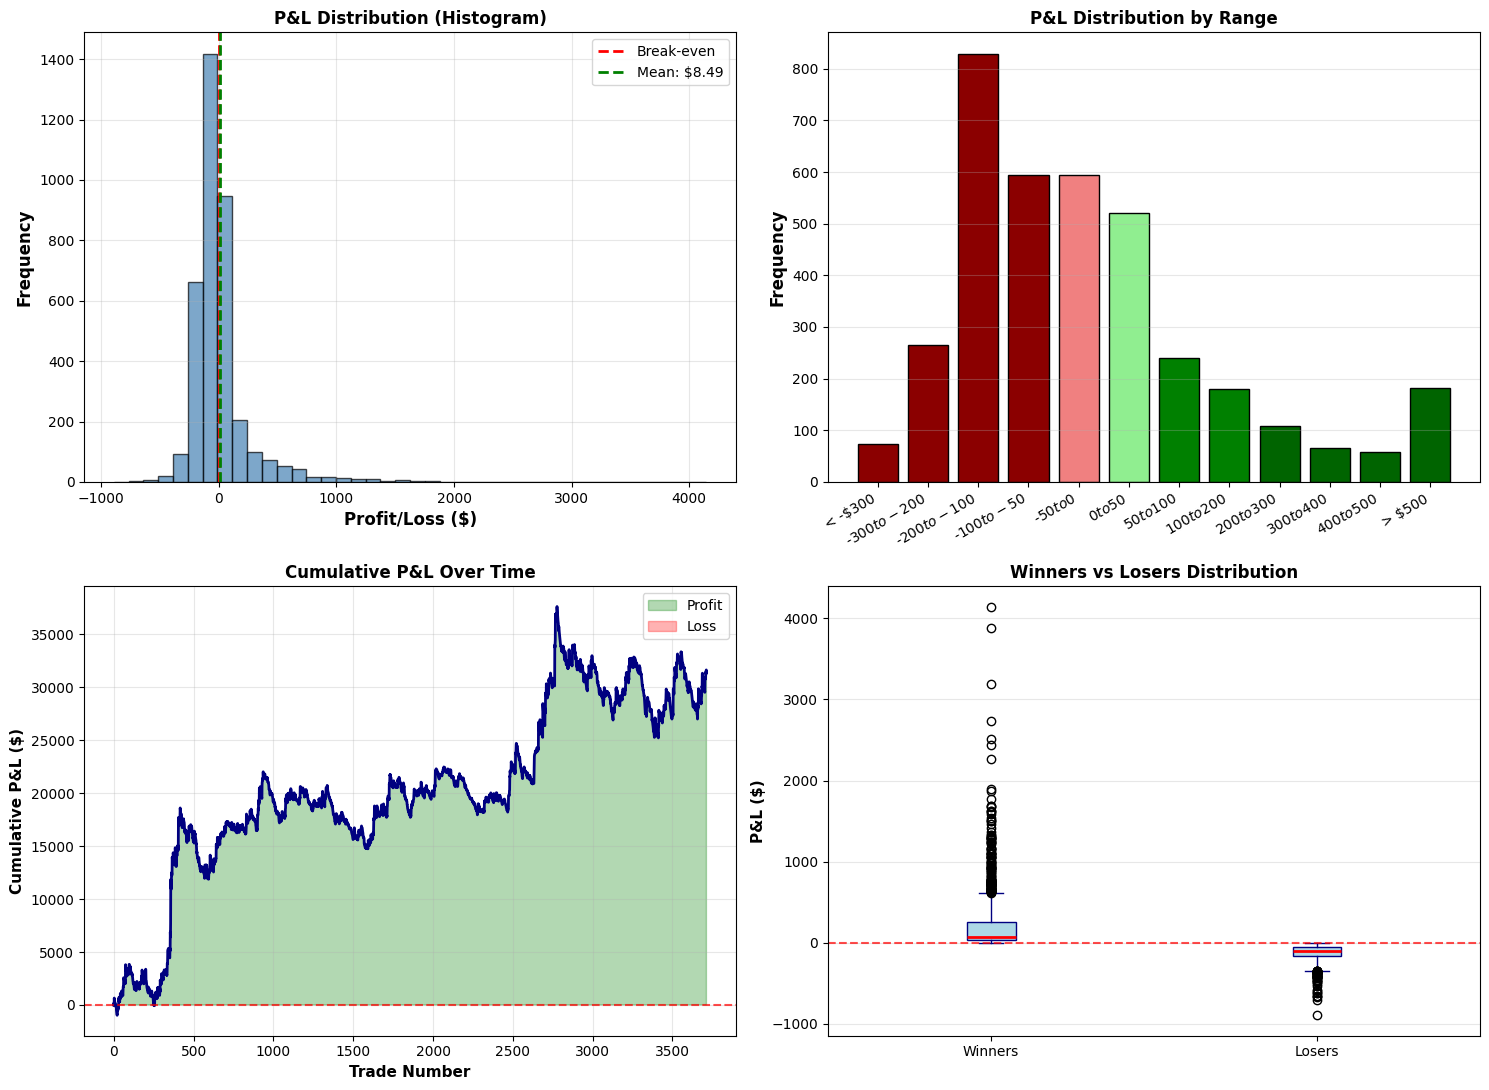



.


In [6]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*60)
    print("  XAUUSD CFD TRADING BACKTEST")
    print("  Configuration: ${:,.0f} Capital | {:.2f} Lots | {} Pip Stop Loss".format(
        INITIAL_CAPITAL, POSITION_SIZE_LOTS, STOP_LOSS_PIPS))
    print("="*60)

    raw_data = load_data(FILE_PATH)

    if raw_data is not None:
        print_margin_analysis()

        yearly_summary, all_trades = run_backtest(raw_data, start_year=2010, end_year=2024)

        if PRINT_BACKTEST_SUMMARY and yearly_summary:
            print_backtest_summary(yearly_summary)

        if all_trades:
            if PLOT_RETURN_DISTRIBUTION:
                plot_performance_analysis(all_trades)

            print("\n\n.")
            #plot_equity_curve(all_trades)


**Result Analysis:**

- 14-year **Arithmetic Return = 22.52%** --> The strategy is feasible.
- Never exposed to Margin Call Risk --> The lowest account balance stood at USD4720, with a 58% portfolio loss (Max Drawdown).
- Number of trades & Win rates remain stable over years, averaged at 265 trades/year and 36.53% profitable trades --> In average, there will be a trade per trading day.
- **This is a strategy that priorities risk-reward ratio than just win rate**.
- Although 'lose more win less', the average profit per trade still stood at $8.49.
- There are many trades (13.4% among all profitable trades) that the profit is >USD500.
- The median of lose trades stood within the range of (-200 to -100), which is quite make sense since this is the interval where Stop Loss locate.
- The reason why there are still >USD300 losses is because despite a Stop Loss is set at USD180, it is possible that the GOLD price undergo sharp drops within the 15 min interval, and the script can only read it and execute order once the new data point is out.
- These additional losses might be mitigated by the strict real-time Stop Loss Mechanism of a brokerage.

## **Strategy Backtest If Included 2024 & 2025**


  XAUUSD CFD TRADING BACKTEST
  Configuration: $10,000 Capital | 0.30 Lots | 600 Pip Stop Loss
✓ Data loaded successfully. Shape: (485224, 5)
✓ Date range: 2004-06-11 07:15:00 to 2025-08-01 11:45:00

  MARGIN REQUIREMENT ANALYSIS
+--------------+------------------+-------------------+------------+
| Gold Price   | Notional Value   | Margin Required   | Margin %   |
+==============+==================+===================+============+
| $1500        | $45,000          | $450.00           | 4.50%      |
+--------------+------------------+-------------------+------------+
| $2000        | $60,000          | $600.00           | 6.00%      |
+--------------+------------------+-------------------+------------+
| $2500        | $75,000          | $750.00           | 7.50%      |
+--------------+------------------+-------------------+------------+
| $3000        | $90,000          | $900.00           | 9.00%      |
+--------------+------------------+-------------------+------------+
| $3500   

/tmp/ipython-input-1023897737.py:198: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot([winners, losers], labels=['Winners', 'Losers'],


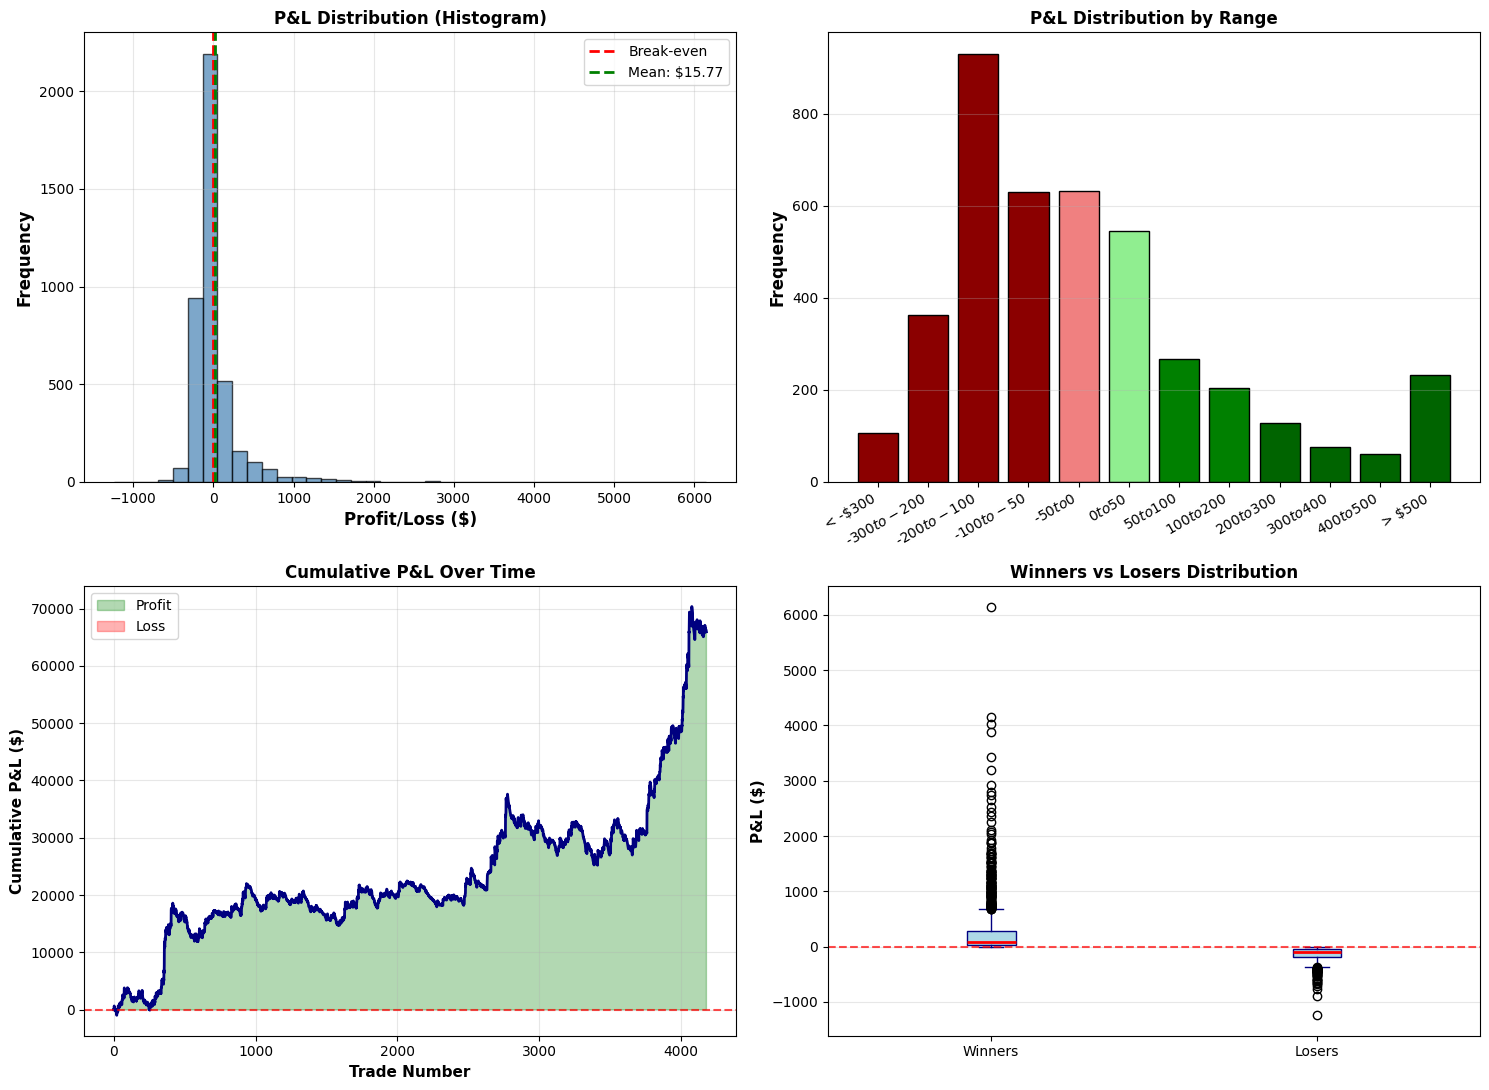



.


In [7]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*60)
    print("  XAUUSD CFD TRADING BACKTEST")
    print("  Configuration: ${:,.0f} Capital | {:.2f} Lots | {} Pip Stop Loss".format(
        INITIAL_CAPITAL, POSITION_SIZE_LOTS, STOP_LOSS_PIPS))
    print("="*60)

    raw_data = load_data(FILE_PATH)

    if raw_data is not None:
        print_margin_analysis()

        yearly_summary, all_trades = run_backtest(raw_data, start_year=2010, end_year=2026)

        if PRINT_BACKTEST_SUMMARY and yearly_summary:
            print_backtest_summary(yearly_summary)

        if all_trades:
            if PLOT_RETURN_DISTRIBUTION:
                plot_performance_analysis(all_trades)

            print("\n\n.")
            #plot_equity_curve(all_trades)


**Result Analysis:**

- 16-year **Arithmetic Return doubled to 41.21%** after including 2024 & 2025, which is not really sustainable --> The GOLD price surge is mainly due to the escalation of international tensions, which include:
1. The escalating US-China trade war
2. The slowly advancing trend of De-dollarization
3. The potential US debt crisis (extremely low yet extremely impactful)
4. The depreciation of US dollar (due to quantitative easing and rate cuts)
5. US president Trump's return to power
6. Central banks around the world increasing gold reserves
7. The fear of AI bubble to be the next Dotcom bubble, etc.

- Number of trades and Win rate remain stable compared to previous years.
- 2025 have significant less trades because the latest available data is only up to August 01, 2025.
- After including 2024 & 2025, the profit factor rise to 1.20 from 1.12.
- I believe that to verify the feasibility of the strategy, we should exclude 2024 & 2025 (while these two years can be perceived as 'BONUS').


**Comparing with the percentage of gold price below EMA200:**
- The years with negative return: 2015, 2018, 2021, 2022.
- The years with outstanding (>100%) return: 2011, 2020, 2024, 2025.
- The correlation is super significant: **This strategy is particularly vulnerable to sideway movements** (generally, the price have around 50% below EMA200), interestingly, not necessary during the bear market (from 2013 to 2015).
- 2013 & 2014 despite weak performance, but overall still profitable.

## **Limitations & Recommendations**

- This strategy backtest **does not take transaction costs** (spread difference, brokerage fee, overnight fee, etc.) **into account**, so the profits might be further squeezed and losses might be amplified.
- The strategy is effective on past performance but may become ineffective in future market conditions.
- Can apply ***Monte Carlo experiments*** to validate the robustness in a comprehensive picture (boostrap/resampling, volatility scaling scenarios, fat-tail scenarios, stress-testing, etc.).